In [2]:
from __future__ import division, print_function

In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import time
import numpy as np

from director import viewerclient as vc
from irispy import Polyhedron
import boxatlas as box
from contactstabilization import contact_stabilize

In [5]:
vis = vc.Visualizer()

In [37]:
np.sum(np.zeros((2,2)))

0.0

In [117]:
surfaces = [
    box.Surface(Polyhedron.fromBounds([1.5, 0], [1.5, 2]),
            Polyhedron(np.array([[1, -1], [1, 1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-1, 0], [1, 0]), 
            Polyhedron(np.array([[-1, -1], [1, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-1, 0], [1, 0]), 
            Polyhedron(np.array([[-1, -1], [1, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [-2, 2]),
            Polyhedron(np.array([[-1, -1], [-1, 1]]), np.array([0, 0]))),
]

env = box.Environment(surfaces)
atlas = box.BoxAtlas()
initial_state = box.BoxAtlasState(atlas)
initial_state.qcom = np.array([0, 1])
initial_state.vcom = np.array([3.5, 0])
initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, .25], [-0.25, .25], [-0.75, 1]])

states, inputs, contact_indicator = contact_stabilize(initial_state, env)

SolutionResult.kSolutionFound


In [118]:
for t in np.linspace(0, states.components[0].breaks[-1] - 0.001, 100):
    box.draw(vis, states(t), inputs(t))
    time.sleep(0.05)

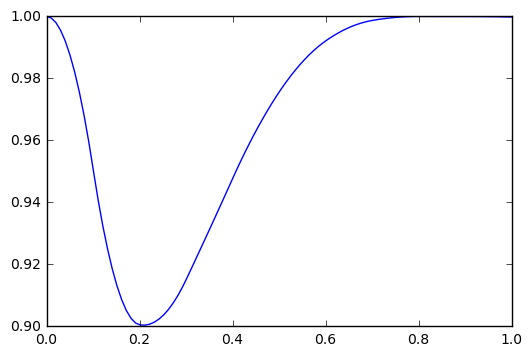

In [82]:
ts = np.linspace(0, states.components[0].breaks[-1] - 0.001, 100)
plot(ts, [states(t).qcom[1] for t in ts])

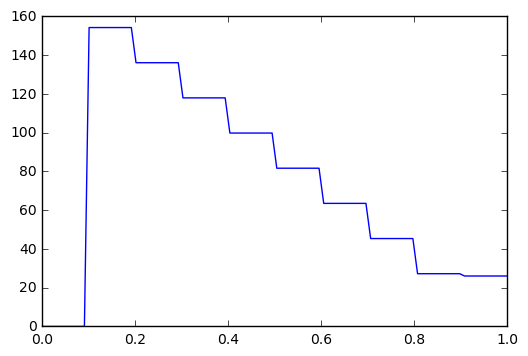

In [64]:
plot(ts, [sum(inputs(t).flimb[k][1] for k in range(4)) for t in ts])

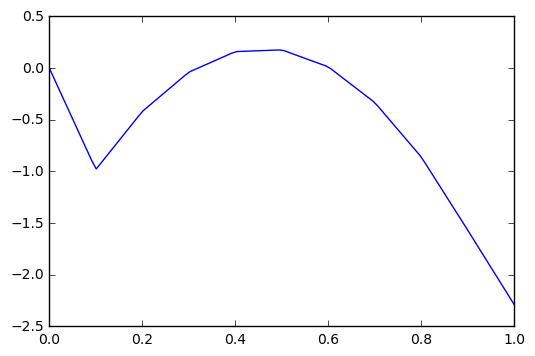

In [65]:
plot(ts, [states(t).vcom[1] for t in ts])